In [55]:
import os
import sys

sys.path.append('/home/julien/Bureau/Julien/02_DATA_PROJECTS/Maintenance')

import config

import pandas as pd
import numpy as np


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

from src.utils.Functions import get_metrics

In [56]:
df_base = pd.read_csv(os.path.join(config.DATA_DIR, 'maintenance_data_base.csv'))

In [57]:
# Pipeline

#Definition des col num et cat
num_col = ['Air_Temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_Wear']
cat_col = ['Type', 'Failure_type']

# Standard scale pour numeric et one hot pour categories
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])
cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])
# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, num_col),
    ('cat_trans', cat_pipeline, cat_col)
])
# Entrainement sur les data preprocessor
df_transformed = preprocessor.fit_transform(df_base)


# Nouveau noms pour les colonnes one hot
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(cat_col)
new_column_names = list(num_col) + list(encoded_feature_names)
df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)
df_transformed.head()

,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Type_H,Type_L,Type_M,Failure_type_HDF,Failure_type_No_failure,Failure_type_OSF,Failure_type_PWF,Failure_type_TWF
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [58]:
# exportation df
df_transformed.to_csv(os.path.join(config.DATA_DIR, 'maintenance_data_clean.csv'))

## Dimension_reduction  
#### pour ne garder que les features determinantes

In [59]:

df = pd.read_csv(os.path.join(config.DATA_DIR, 'maintenance_data_clean.csv'), index_col = 'Unnamed: 0')
df

,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Type_H,Type_L,Type_M,Failure_type_HDF,Failure_type_No_failure,Failure_type_OSF,Failure_type_PWF,Failure_type_TWF
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.602417,-1.082162,0.363820,-1.052012,-1.476034,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9996,-0.552421,-1.082162,0.520005,-0.821283,-1.428902,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9997,-0.502425,-0.947360,0.592519,-0.660777,-1.350349,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9998,-0.502425,-0.879959,-0.729472,0.854005,-1.303217,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


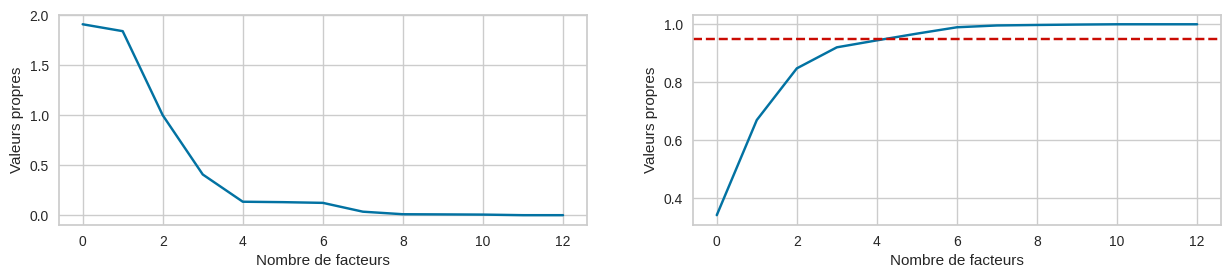

In [60]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df)

plt.figure(figsize=(15, 6))

plt.subplot(2,2,1)
plt.plot(range(0,13), pca.explained_variance_)
plt.xlabel('Nombre de facteurs')
plt.ylabel('Valeurs propres')

plt.subplot(2,2,2)
plt.plot(range(0,13), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de facteurs')
plt.ylabel('Valeurs propres')
plt.axhline(y=0.95, color = 'r', linestyle = '--')


In [61]:
pca = PCA(n_components=0.95)
pca.fit(df)
print('number of usefull component', pca.n_components_)

number of usefull component 6


#### which feature is the most important

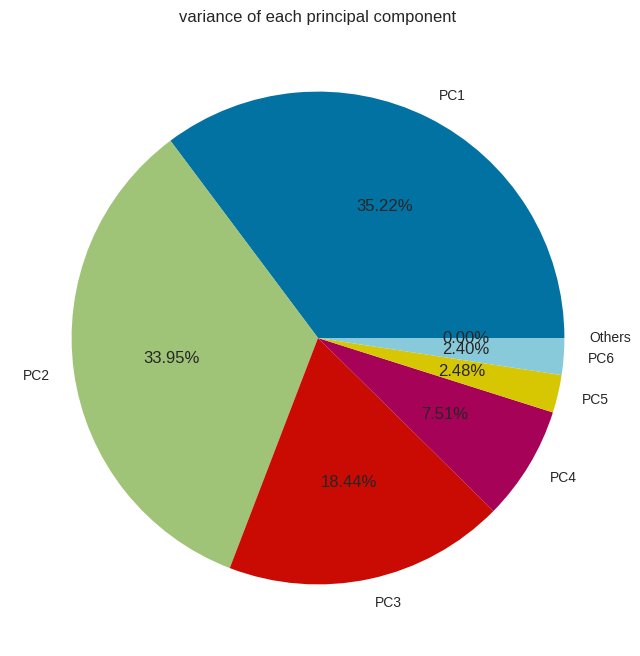

In [62]:
L1 = list(pca.explained_variance_ratio_[0:7])
L1.append(sum(pca.explained_variance_ratio_[7:14]))

plt.figure(figsize=(10, 8))
plt.pie(L1, labels=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'Others'], 
        autopct='%1.2f%%')

plt.title("variance of each principal component")
plt.show()


##

# MODELING

In [63]:
pca = PCA(n_components=6)  # Nombre de composantes principales à conserver
pca.fit(df)
pc = pca.transform(df)



In [64]:
df

,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Type_H,Type_L,Type_M,Failure_type_HDF,Failure_type_No_failure,Failure_type_OSF,Failure_type_PWF,Failure_type_TWF
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.602417,-1.082162,0.363820,-1.052012,-1.476034,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9996,-0.552421,-1.082162,0.520005,-0.821283,-1.428902,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9997,-0.502425,-0.947360,0.592519,-0.660777,-1.350349,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9998,-0.502425,-0.879959,-0.729472,0.854005,-1.303217,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### separate train - test

In [65]:
df_base = df_base.set_index('UDI')
df_base

,Type,Air_Temperature,Process_temperature,Rotational_speed,Torque,Tool_Wear,Failure_type
UDI,,,,,,,
1,M,298.1,308.6,1551,42.8,0,No_failure
2,L,298.2,308.7,1408,46.3,3,No_failure
3,L,298.1,308.5,1498,49.4,5,No_failure
4,L,298.2,308.6,1433,39.5,7,No_failure
5,L,298.2,308.7,1408,40.0,9,No_failure
...,...,...,...,...,...,...,...
9996,M,298.8,308.4,1604,29.5,14,No_failure
9997,H,298.9,308.4,1632,31.8,17,No_failure
9998,M,299.0,308.6,1645,33.4,22,No_failure


In [66]:
df_model = df_base.copy()

num_cat = ['Air_Temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_Wear']
text_cat = ['Type']



## Train test split

In [67]:
X = df_model[num_cat + text_cat]
y = df_model['Failure_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [70]:
pip_model_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('model', RandomForestClassifier(random_state=2023))
])

# Fit pipeline with PCA
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model_pca.fit(X_train, y_train, model__sample_weight=weights)

# Generate Predictions using the correctly fitted pipeline
y_pred = pip_model_pca.predict(X_test)

# Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# View Results
metrics

ValueError: could not convert string to float: 'L'